In [1]:
import sys,os,pickle,copy
sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
import numpy as np
import numpy
import pandas as pd
import scipy
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload
import seaborn as sns

import preprocess as prep

from sklearn.decomposition import NMF

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
import matplotlib.pyplot as plt

import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

<module 'nmf_analysis' from '/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py'>

In [2]:
sess_name="e15_13f1_220117"#'e13_26m1_210913'#
data_dir_full = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117"#'/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913' #
py_data_dir = os.path.join(data_dir_full,"py_data")
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=numpy.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr = fr_['df']['pyr']
fr_map_trial = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']
fr_map_avg=pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map']
cell_cols = fr_['cell_cols']
cell_cols_pyr=np.array(cell_cols['pyr'],dtype=object)

In [3]:
data_dir_full = data_dir_full
to_return=prep.load_stuff(data_dir_full)

cell_metrics=to_return['cell_metrics']
behavior=to_return['behavior']
ripple_events=to_return['ripple_events']
mergepoints=to_return['mergepoints']
cell_type_mask=to_return['cell_type_mask']
pyr_uid=to_return['pyr_uid']

trial_ind_d = {ch:np.nonzero(behavior.trials.visitedArm==ch)[0] for ch in [0,1]}
dt = np.diff(behavior.timestamps).mean()

In [4]:
fr_filtered = copy.copy(fr.query("(speed>=1.)"))
# fr_filtered[cell_cols_pyr] = fr_filtered[cell_cols_pyr] / dt
nbins = 10
fr_filtered['lin_binned'] = pd.cut(fr_filtered['lin'],nbins,retbins=False,labels=False)
fr_mean_trial_type = fr_filtered.groupby(['visitedArm','trial','lin_binned']).mean()[cell_cols_pyr]
# fr_mean_all = fr_filtered.groupby('trial').mean()[cell_cols_pyr]

# fr_to_be_nmfed = {'0':fr_mean_trial_type.loc[0],'1':fr_mean_trial_type.loc[1],'both':fr_mean_all}

In [5]:
fr_to_be_nmfed_one_trialtype=fr_mean_trial_type.loc[0]

trial_position_index = fr_to_be_nmfed_one_trialtype.index

X_normed,pyr_mask,non_na_original_ind=na.normalize(fr_to_be_nmfed_one_trialtype.values.T)

X_normed_restacked_df = pd.DataFrame(X_normed,columns=trial_position_index).stack()
neuron_position_index=X_normed_restacked_df.index
X_normed_restacked = X_normed_restacked_df.values # (nneuron x npos) x ntrials



n_compo = 4
W, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted = na.nmf_and_sort(X_normed_restacked, n_compo, model=None)




W_df = pd.DataFrame(W,neuron_position_index)

In [9]:
n_compo = 4
W_df, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted = na.nmf_sort_with_position(fr_to_be_nmfed_one_trialtype, n_compo, do_normalize=True)



In [10]:
W_df

0         1         2         3
    lin_binned                                        
0   0           0.043654  0.118761  0.085496  0.181378
    1           0.027195  0.123321  0.037680  0.055281
    2           0.000000  0.028357  0.018872  0.034561
    3           0.020145  0.019696  0.019179  0.031391
    4           0.053287  0.065331  0.028987  0.016535
...                  ...       ...       ...       ...
332 5           0.000000  0.000069  0.001086  0.000000
    6           0.000000  0.000000  0.000000  0.000000
    7           0.000000  0.000000  0.000000  0.000000
    8           0.000000  0.000607  0.001353  0.003711
    9           0.004239  0.042753  0.000000  0.000000

[3330 rows x 4 columns]

In [6]:
fr_to_be_nmfed_one_trialtype

unit_31   unit_32   unit_33   unit_34   unit_35   unit_36  \
trial lin_binned                                                               
0.0   0           0.027778  0.222222  0.013889  0.041667  0.055556  0.125000   
      1           0.000000  0.062500  0.000000  0.000000  0.000000  0.125000   
      2           0.000000  0.000000  0.000000  0.080000  0.000000  0.000000   
      3           0.050000  0.000000  0.000000  0.016667  0.050000  0.066667   
      4           0.116279  0.046512  0.000000  0.046512  0.069767  0.046512   
...                    ...       ...       ...       ...       ...       ...   
33.0  5           0.061475  0.004098  0.024590  0.135246  0.069672  0.147541   
      6           0.434783  0.000000  0.000000  0.000000  0.000000  0.130435   
      7           0.285714  0.000000  0.000000  0.047619  0.095238  0.142857   
      8           0.032258  0.145161  0.008065  0.008065  0.032258  0.064516   
      9           0.047619  0.000000  0.000000  0.000000  0.000000  0.190476   

                   unit_37   unit_38  unit_39   unit_40  ...  unit_367  \
trial lin_binned                                         ...             
0.0   0           0.083333  0.000000      0.0  0.180556  ...  0.027778   
      1           0.187500  0.062500      0.0  0.375000  ...  0.062500   
      2           0.000000  0.080000      0.0  0.080000  ...  0.000000   
      3           0.116667  0.000000      0.0  0.066667  ...  0.000000   
      4           0.023256  0.000000      0.0  0.209302  ...  0.000000   
...                    ...       ...      ...       ...  ...       ...   
33.0  5           0.016393  0.012295      0.0  0.110656  ...  0.004098   
      6           0.000000  0.000000      0.0  0.000000  ...  0.000000   
      7           0.142857  0.000000      0.0  0.000000  ...  0.000000   
      8           0.161290  0.048387      0.0  0.209677  ...  0.000000   
      9           0.190476  0.333333      0.0  0.714286  ...  0.000000   

                  unit_368  unit_369  unit_370  unit_371  unit_372  unit_373  \
trial lin_binned                                                               
0.0   0           0.000000  0.000000  0.111111  0.013889       0.0       0.0   
      1           0.000000  0.000000  0.062500  0.000000       0.0       0.0   
      2           0.000000  0.000000  0.120000  0.000000       0.0       0.0   
      3           0.016667  0.000000  0.066667  0.016667       0.0       0.0   
      4           0.046512  0.000000  0.046512  0.000000       0.0       0.0   
...                    ...       ...       ...       ...       ...       ...   
33.0  5           0.008197  0.012295  0.012295  0.004098       0.0       0.0   
      6           0.000000  0.000000  0.000000  0.000000       0.0       0.0   
      7           0.000000  0.000000  0.047619  0.000000       0.0       0.0   
      8           0.233871  0.137097  0.024194  0.112903       0.0       0.0   
      9           0.000000  0.000000  0.095238  0.000000       0.0       0.0   

                  unit_374  unit_375  unit_376  
trial lin_binned                                
0.0   0               0.00  0.000000  0.402778  
      1               0.00  0.000000  0.000000  
      2               0.00  0.000000  0.000000  
      3               0.05  0.000000  0.000000  
      4               0.00  0.000000  0.000000  
...                    ...       ...       ...  
33.0  5               0.00  0.000000  0.000000  
      6               0.00  0.000000  0.000000  
      7               0.00  0.000000  0.000000  
      8               0.00  0.000000  0.000000  
      9               0.00  0.095238  0.000000  

[210 rows x 333 columns]

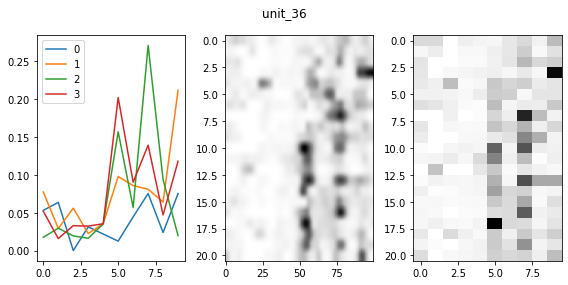

In [8]:
ii=5
k=0
fig,axs=plt.subplots(1,3,figsize=(8,4))
axs[0].plot(W_df.loc[ii])
axs[0].legend(range(n_compo))
axs[1].imshow(fr_map_trial[k][non_na_original_ind[ii]].T,aspect='auto')
axs[2].imshow(X_normed_restacked_df.loc[ii].T,aspect='auto')
fig.suptitle(cell_cols_pyr[non_na_original_ind[ii]])
plt.tight_layout()

In [13]:
reload(na)
W_df=na.add_metrics_to_W(W_df,n_compo)

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_entropy.py:77: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:234: RuntimeWarning: invalid value encountered in double_scalars
  return (x[i] - x.mean())**3/x.std()**3
/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:234: RuntimeWarning: invalid value encountered in double_scalars
  return (x[i] - x.mean())**3/x.std()**3
/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:234: RuntimeWarning: invalid value encountered in double_scalars
  return (x[i] - x.mean())**3/x.std()**3
/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:234: RuntimeWarning: invalid value encountered in double_scalars
  return (x[i] - x.mean())**3/x.std()**3


In [11]:
reload(na)
final_sort_key='skew'
to_cut_keys=['sum']
W_df_sorted = na.hierarchical_sort(W_df,to_cut_keys=to_cut_keys,to_cut_nbins=[2],final_sort_key=final_sort_key,ascending=False)
# W_df_sorted = W_df.sort_values('skew',ascending=False)



In [143]:
# mean_w_by_pos_sorted = W_df['sum'].groupby(level=0).mean().sort_values(ascending=False)
# mean_w_by_pos_sorted

17     0.426978
16     0.381931
14     0.361790
21     0.328111
3      0.326672
         ...   
193    0.017383
253    0.016983
186    0.016536
328    0.015825
231    0.012021
Name: sum, Length: 333, dtype: float64

In [15]:
reload(na)

<module 'nmf_analysis' from '/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py'>

In [16]:
# suppose each neuron, get the max among ws at each pos bin, use that max value to pick out the field, then look 
# at how sparse the w is. sparse shows dynamics.
# w_max_across_trial = W_df.loc[:,0:n_compo-1].max(axis=1).unstack()

# peaks_l = []
# peaks_l_all = []
# heights_l = []
# for n in range(w_max_across_trial.shape[0]):
#     xx=w_max_across_trial.iloc[n]
#     peaks = scipy.signal.find_peaks(xx)[0]
# #     heights= xx[peaks]
# #     heights = scipy.stats.zscore(heights)
#     peaks_l.append(peaks)
#     peaks_l_all.extend((n,p) for p in peaks)
# #     heights_l.extend(heights)

# W_df_peaks_only = W_df.loc[peaks_l_all]
W_df_peaks_only = na.get_peaks_in_W(W_df,n_compo)

W_df_peaks_only_inds,_,_=na.sort_factors(W_df_peaks_only.loc[:,0:n_compo-1].values)
W_df_peaks_only_sorted=W_df_peaks_only.iloc[W_df_peaks_only_inds]

In [13]:
f=3
sorted_inds_for_sparseness = na.hierarchical_sort(W_df_peaks_only_sorted,[f'skew_{f}','skew'],[4,4],f,ascending=False)


In [554]:
sorted_inds_for_sparseness

,,0,1,2,3,sum,0_normed,1_normed,2_normed,3_normed,entropy,skew,skew_0,skew_1,skew_2,skew_3,skew_3_binned,skew_binned
,lin_binned,,,,,,,,,,,,,,,,,
88,2,0.000000,0.000000,0.017405,0.319440,0.336846,0.000000,0.000000,0.051671,0.948329,0.203406,1.145370,-0.237433,-0.237433,-0.118544,5.174889,3,3
82,3,0.048952,0.061980,0.087366,0.299489,0.497787,0.098339,0.124511,0.175508,0.601641,1.098570,1.092668,-0.405454,-0.229689,-0.048045,5.053862,3,3
90,7,0.021021,0.021895,0.044063,0.296546,0.383525,0.054810,0.057089,0.114890,0.773210,0.770088,1.133294,-0.267239,-0.257987,-0.088631,5.147031,3,3
163,6,0.120206,0.100310,0.082170,0.292174,0.594860,0.202074,0.168629,0.138133,0.491165,1.245955,1.066798,-0.039219,-0.191953,-0.498755,4.997119,3,3
80,7,0.005402,0.046191,0.076546,0.272135,0.400274,0.013496,0.115398,0.191235,0.679872,0.885970,0.946382,-0.787810,-0.145232,-0.012085,4.730656,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,6,0.003060,0.001683,0.001554,0.000000,0.006296,0.486002,0.267244,0.246754,0.000000,1.048623,-0.121356,2.577700,0.001006,-0.000007,-3.064123,0,1
295,7,0.102654,0.100900,0.027991,0.000000,0.231545,0.443344,0.435768,0.120887,0.000000,0.978011,-0.140987,0.984806,0.873520,-0.293267,-2.129008,0,1
143,7,0.022748,0.023087,0.010614,0.000000,0.056448,0.402983,0.408994,0.188023,0.000000,1.046141,-0.423653,0.734235,0.824233,-0.048819,-3.204261,0,1


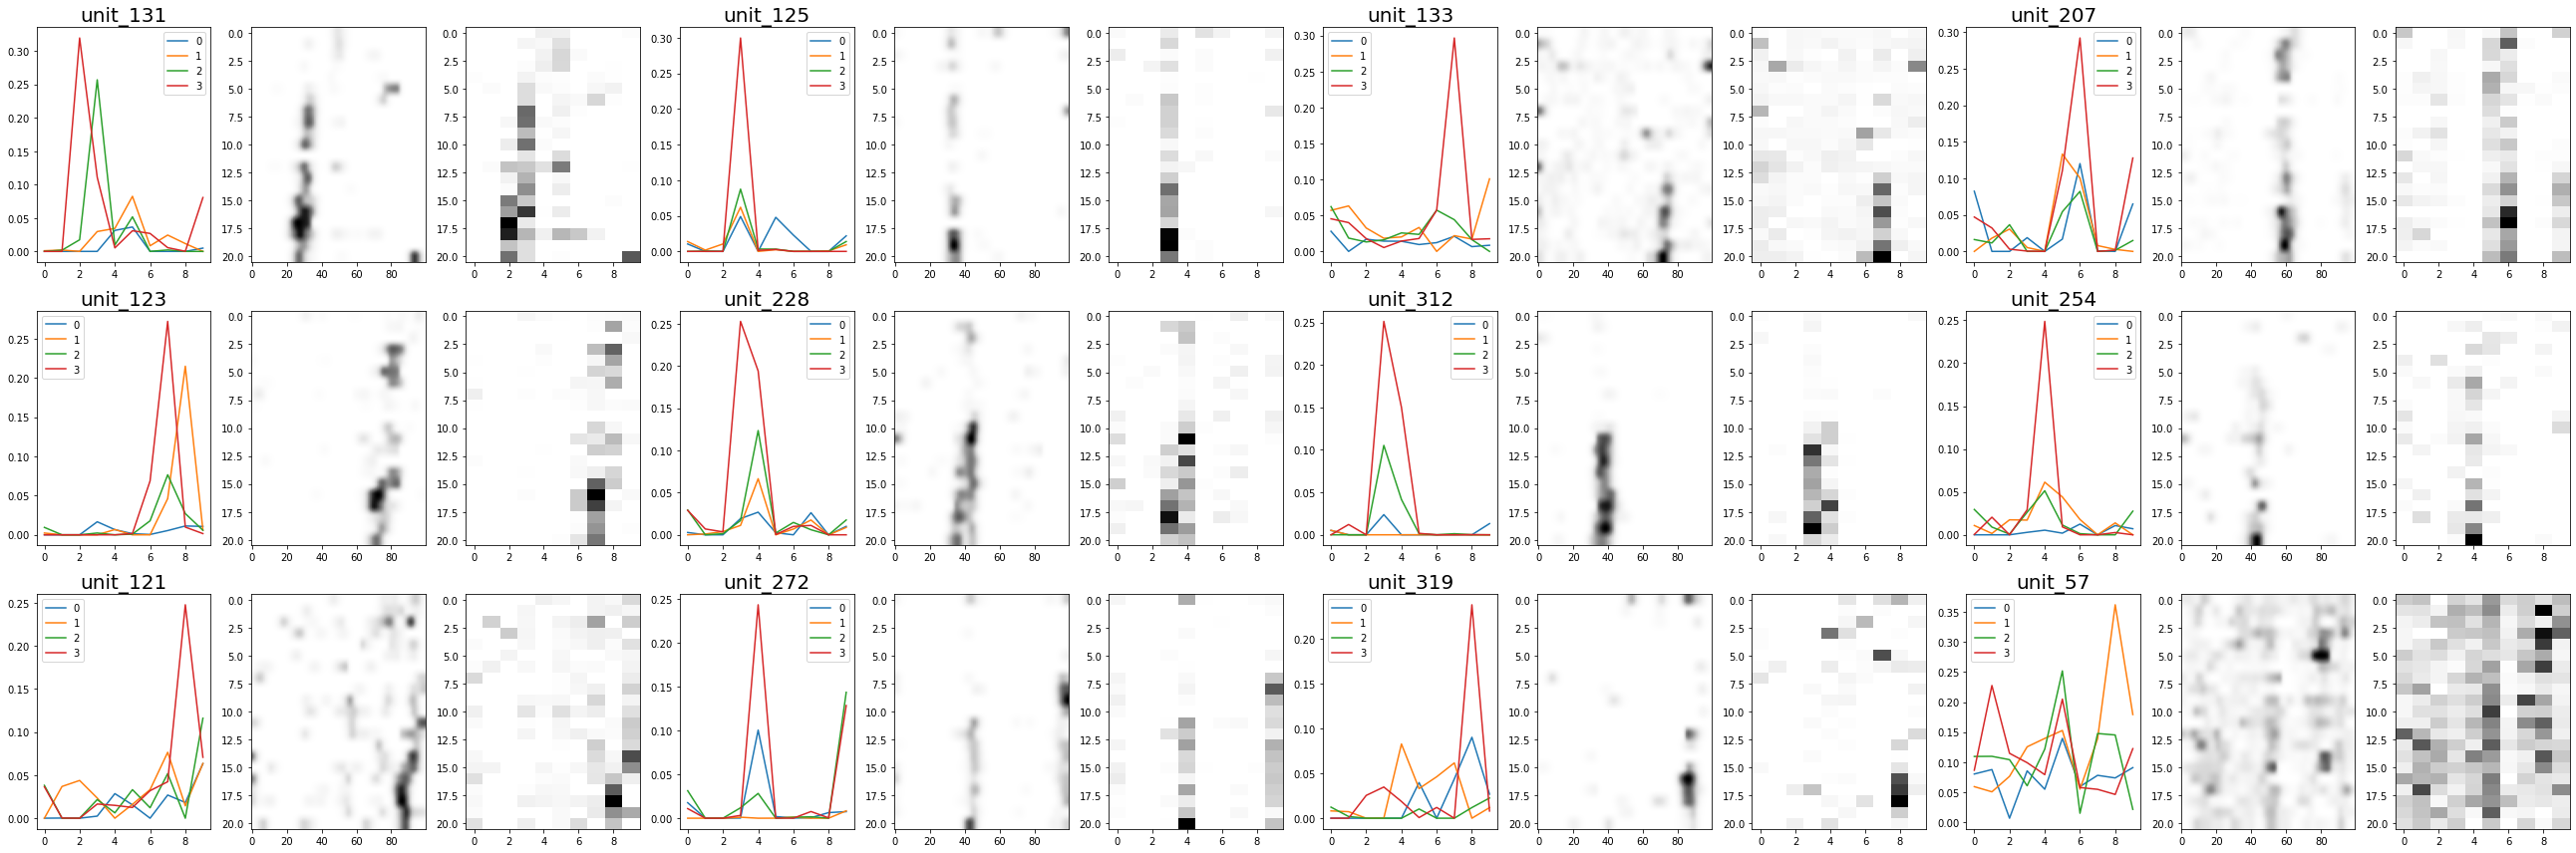

In [555]:
# iii=3

# ii=W_df_sorted.index.get_level_values(0)[iii]
# print(sorted_inds_for_sparseness.iloc[iii])
# ii=sorted_inds_for_sparseness.index.get_level_values(0)[iii]
inds_within_W_l=sorted_inds_for_sparseness.index.get_level_values(0)[:12]

k=0
# fig,axs=plt.subplots(1,3,figsize=(8,4))
# axs[0].plot(W_df.loc[ii,0:n_compo-1])
# axs[0].legend(range(n_compo))
# axs[1].imshow(fr_map_trial[k][non_na_original_ind[ii]].T,aspect='auto')
# axs[2].imshow(X_normed_restacked_df.loc[ii].T,aspect='auto')
# fig.suptitle(cell_cols_pyr[non_na_original_ind[ii]])
# plt.tight_layout()
reload(nmfp)
fig,axs=nmfp.plot_example_W_and_ratemaps(W_df, inds_within_W_l, non_na_original_ind, fr_map_trial[k],X_normed_restacked_df,cell_cols_pyr,n_compo=4)



In [517]:
W_df_peaks_only.loc[:,0:3].corr()

,0,1,2,3
0,1.000000,0.122708,0.028312,0.063133
1,0.122708,1.000000,0.502246,0.380082
2,0.028312,0.502246,1.000000,0.629897
3,0.063133,0.380082,0.629897,1.000000


(<Figure size 666x799.2 with 4 Axes>,
 {'W': <AxesSubplot:label='W', xlabel='component', ylabel='neuron'>,
  'H': <AxesSubplot:label='H', ylabel='component'>})

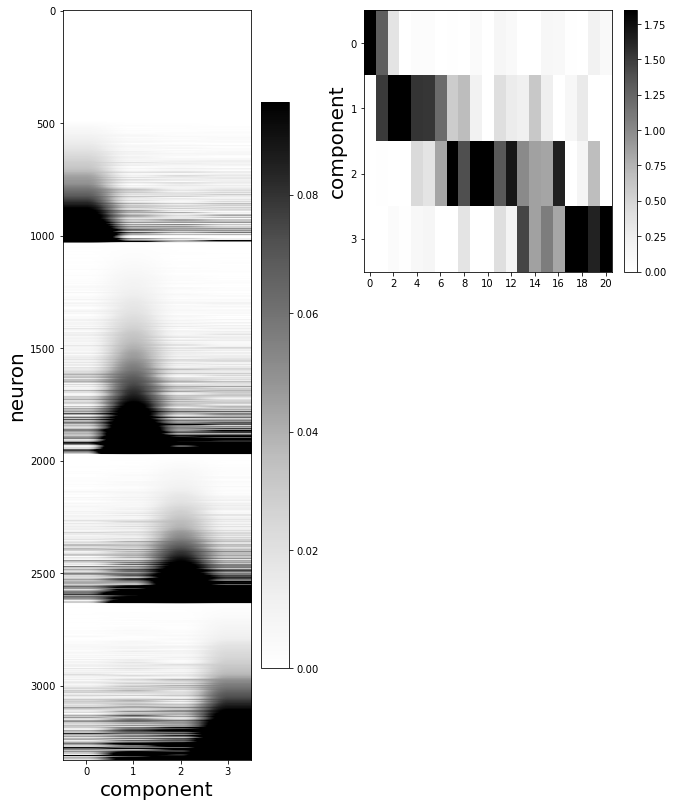

In [105]:
nmfp.plot_wh(W_sorted, H_sorted,factor_neuron_ratio=300,spacing=2)

# try clustering!

In [14]:
X_normed_restacked_df_peaks_only = X_normed_restacked_df.loc[peaks_l_all]

In [604]:
# import ot
# x=np.arange(X_normed_restacked_df_peaks_only.shape[1],dtype=float)
# M = ot.dist(x.reshape((-1, 1)), x.reshape((-1, 1)))
# M /= M.max()

# X_normed_restacked_df_peaks_only_prob = X_normed_restacked_df_peaks_only.values / np.sum(X_normed_restacked_df_peaks_only.values,axis=1,keepdims=True)
# X_normed_restacked_df_peaks_only_prob = X_normed_restacked_df_peaks_only_prob.copy(order='C')


# n_to_compute=X_normed_restacked_df_peaks_only_prob.shape[0]
# D = np.zeros((n_to_compute,n_to_compute))
# for i in range(n_to_compute):
#     for j in range(n_to_compute):
#         D[i,j]=ot.emd2(X_normed_restacked_df_peaks_only_prob[i],X_normed_restacked_df_peaks_only_prob[j],M)

In [15]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [646]:
# n_clust = 6
# models = {'km':KMeans(n_clust),'db':DBSCAN(n_clust,metric='cosine'),'agg':AgglomerativeClustering(n_clust,affinity='cosine',linkage='average')}
# res_d = {}
# for key,model in models.items():
#     if key=='agg':
#         res=model.fit_predict(X_normed_restacked_df_peaks_only_prob,D)
#     else:
#         res=model.fit_predict(X_normed_restacked_df_peaks_only_prob)
#     res_d[key] = res

In [40]:
res=KMeans(6).fit_predict(W_df_peaks_only.loc[:,0:n_compo-1])
W_df_peaks_only['clust']=res
X_normed_restacked_df_peaks_only['clust'] = res

In [21]:
W_df_peaks_only

0         1         2         3       sum   entropy  \
    lin_binned                                                               
0   4           0.053296  0.065546  0.028987  0.016548  0.164377  1.268941   
    7           0.027795  0.194955  0.221096  0.199878  0.643725  1.227648   
1   2           0.000000  0.324651  0.334646  0.141819  0.801116  1.037202   
    4           0.019542  0.000000  0.032242  0.215622  0.267406  0.619821   
    8           0.016772  0.000000  0.003167  0.037294  0.057234  0.798955   
...                  ...       ...       ...       ...       ...       ...   
329 7           0.000000  0.009798  0.000000  0.000000  0.009798  0.000000   
330 3           0.014153  0.000000  0.000000  0.000000  0.014153  0.000000   
    6           0.030195  0.020082  0.000595  0.009952  0.060824  1.054989   
331 4           0.000000  0.007543  0.003295  0.001523  0.012362  0.911873   
332 4           0.000016  0.000000  0.002013  0.000000  0.002029  0.045827   

                    skew    skew_0    skew_1    skew_2    skew_3  km  
    lin_binned                                                        
0   4          -0.004435  0.251198  2.021512 -0.245406 -2.045043   2  
    7          -1.097947 -5.071424  0.084645  0.468031  0.126960   1  
1   2          -0.363150 -3.004834  0.719578  0.907385 -0.074728   1  
    4           1.093581 -0.162718 -0.459113 -0.063705  5.059861   4  
    8           0.618761  0.004716 -0.923951 -0.436156  3.830435   2  
...                  ...       ...       ...       ...       ...  ..  
329 7           1.154701 -0.192450  5.196152 -0.192450 -0.192450   2  
330 3           1.154701  5.196152 -0.192450 -0.192450 -0.192450   2  
    6           0.040510  2.487389  0.085622 -2.303844 -0.107128   2  
331 4           0.610359 -1.312188  3.924334  0.000383 -0.171093   2  
332 4           1.154508 -0.180491 -0.198598  5.195717 -0.198598   2  

[709 rows x 12 columns]

In [22]:
W_df_peaks_only.iloc[W_df_peaks_only_inds]

,,0,1,2,3,sum,entropy,skew,skew_0,skew_1,skew_2,skew_3,km
,lin_binned,,,,,,,,,,,,
288,8,0.001838,0.000779,0.000217,0.000070,0.002904,0.925693,0.717186,4.105589,0.000452,-0.394416,-0.842881,2
161,6,0.003061,0.001694,0.001557,0.000000,0.006312,1.049258,-0.130913,2.557425,0.001240,-0.000008,-3.082308,2
196,4,0.003840,0.000193,0.000433,0.000000,0.004465,0.491437,1.122372,5.123012,-0.199810,-0.081042,-0.352670,2
250,5,0.005221,0.000000,0.000074,0.002090,0.007384,0.648286,0.696500,4.027052,-0.659153,-0.583415,0.001517,2
234,5,0.006146,0.000000,0.003082,0.000000,0.009229,0.636966,0.490569,3.417468,-0.741655,0.028120,-0.741655,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2,0.000000,0.000000,0.017433,0.319354,0.336787,0.203674,1.145334,-0.237523,-0.237523,-0.118424,5.174808,4
20,7,0.072648,0.205598,0.228166,0.323165,0.829577,1.281277,-0.309612,-3.420075,-0.000008,0.012528,2.169108,1
54,7,0.041670,0.041403,0.193913,0.331158,0.608144,1.062052,0.444051,-0.764811,-0.770376,0.041780,3.269613,1


In [28]:
gpb.mean().loc[:,0:3].T

km,0,1,2,3,4,5
0,0.055827,0.034298,0.050766,0.015068,0.034254,0.170683
1,0.249763,0.032411,0.144723,0.028966,0.070271,0.042022
2,0.106662,0.041313,0.231587,0.012600,0.116356,0.023919
3,0.101097,0.166132,0.225865,0.015623,0.072249,0.027306


clust
0     51
1     70
2     79
3     77
4    331
5    101
Name: 0, dtype: int64


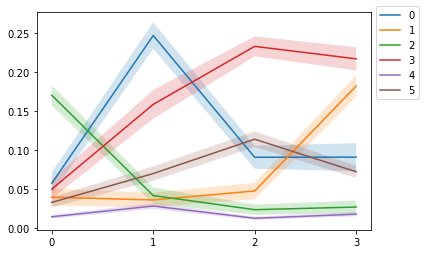

In [80]:
gpb=W_df_peaks_only.groupby('clust')
print(gpb.count().iloc[:,0])
# ax=gpb.mean().loc[:,0:3].T.plot()
# ax.set_xticks([0,1,2,3])

compo_list = list(range(0,n_compo))
gpb = W_df_peaks_only.loc[:,compo_list+['clust']].groupby('clust')
fig,ax=plt.subplots()
for k,val in gpb:
    val = val.loc[:,val.columns!='clust']
    m = val.mean()
    sem = val.sem()
    ci = 1.96
    ax.plot(m,label=k)
    ax.fill_between(m.index.astype(float),m-sem * ci,m+sem*ci,alpha=0.2)
ax.set_xticks(compo_list)
plt.legend(bbox_to_anchor=[1,1.05])
    

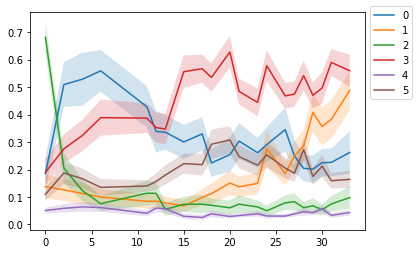

In [75]:
gpb = X_normed_restacked_df_peaks_only.groupby('clust')
fig,ax=plt.subplots()
for k,val in gpb:
    val = val.loc[:,val.columns!='clust']
    m = val.mean()
    sem = val.sem()
    ci = 1.96
    ax.plot(m,label=k)
    ax.fill_between(m.index.astype(float),m-sem * ci,m+sem*ci,alpha=0.2)
plt.legend(bbox_to_anchor=[1,1.05])
    

In [81]:
W_df_peaks_only

0         1         2         3       sum   entropy  \
    lin_binned                                                               
0   4           0.053296  0.065546  0.028987  0.016548  0.164377  1.268941   
    7           0.027795  0.194955  0.221096  0.199878  0.643725  1.227648   
1   2           0.000000  0.324651  0.334646  0.141819  0.801116  1.037202   
    4           0.019542  0.000000  0.032242  0.215622  0.267406  0.619821   
    8           0.016772  0.000000  0.003167  0.037294  0.057234  0.798955   
...                  ...       ...       ...       ...       ...       ...   
329 7           0.000000  0.009798  0.000000  0.000000  0.009798  0.000000   
330 3           0.014153  0.000000  0.000000  0.000000  0.014153  0.000000   
    6           0.030195  0.020082  0.000595  0.009952  0.060824  1.054989   
331 4           0.000000  0.007543  0.003295  0.001523  0.012362  0.911873   
332 4           0.000016  0.000000  0.002013  0.000000  0.002029  0.045827   

                    skew    skew_0    skew_1    skew_2    skew_3  km  clust  
    lin_binned                                                               
0   4          -0.004435  0.251198  2.021512 -0.245406 -2.045043   3      4  
    7          -1.097947 -5.071424  0.084645  0.468031  0.126960   2      3  
1   2          -0.363150 -3.004834  0.719578  0.907385 -0.074728   2      3  
    4           1.093581 -0.162718 -0.459113 -0.063705  5.059861   1      1  
    8           0.618761  0.004716 -0.923951 -0.436156  3.830435   3      4  
...                  ...       ...       ...       ...       ...  ..    ...  
329 7           1.154701 -0.192450  5.196152 -0.192450 -0.192450   3      4  
330 3           1.154701  5.196152 -0.192450 -0.192450 -0.192450   3      4  
    6           0.040510  2.487389  0.085622 -2.303844 -0.107128   3      4  
331 4           0.610359 -1.312188  3.924334  0.000383 -0.171093   3      4  
332 4           1.154508 -0.180491 -0.198598  5.195717 -0.198598   3      4  

[709 rows x 13 columns]

In [87]:
W_df_peaks_only.query('clust==@f').index[:12]

MultiIndex([( 8, 2),
            ( 9, 4),
            (10, 8),
            (11, 4),
            (16, 2),
            (19, 3),
            (19, 7),
            (20, 1),
            (21, 1),
            (23, 3),
            (24, 2),
            (25, 7)],
           names=[None, 'lin_binned'])

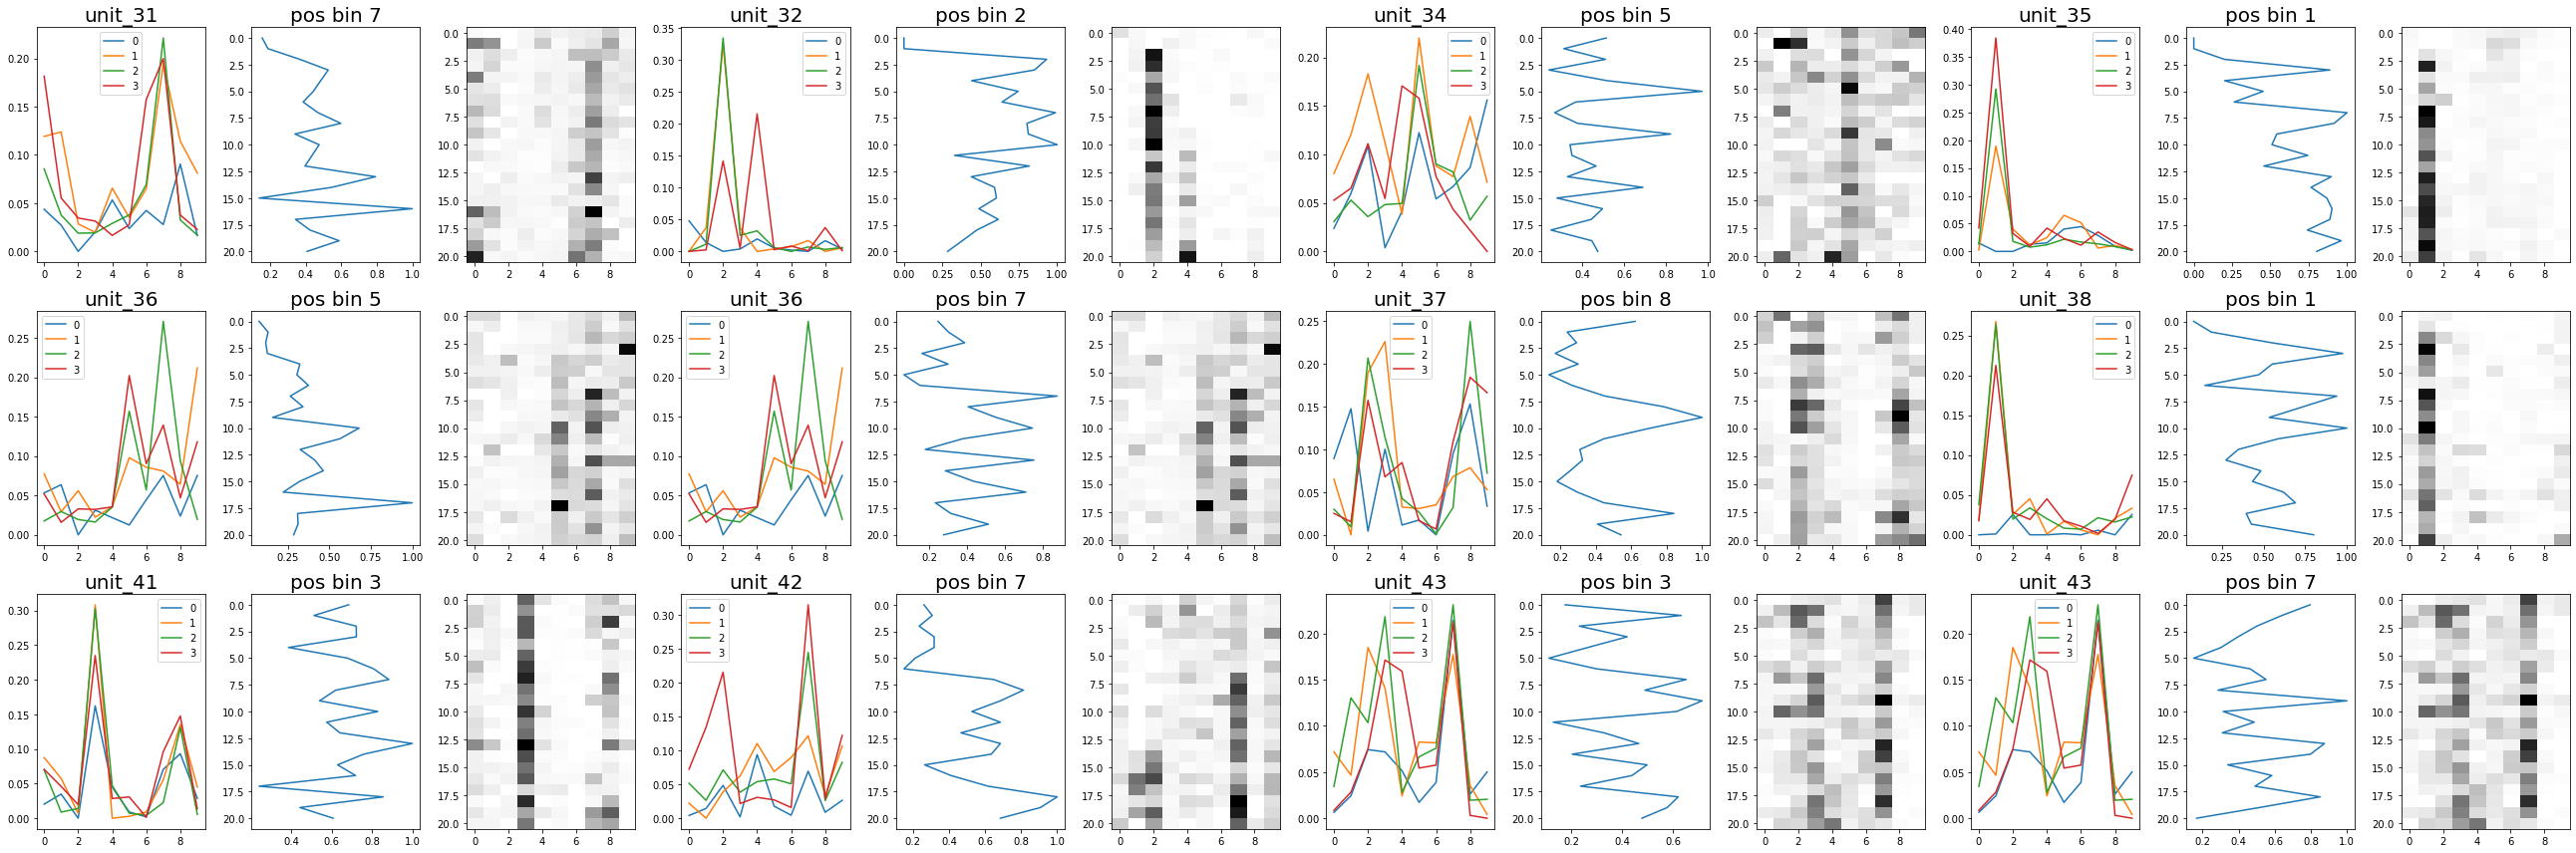

In [95]:
# iii=3

# ii=W_df_sorted.index.get_level_values(0)[iii]
# print(sorted_inds_for_sparseness.iloc[iii])
# ii=sorted_inds_for_sparseness.index.get_level_values(0)[iii]
f=3
# inds_within_W_l=W_df_peaks_only.query('clust==@f').index.get_level_values(0)[:12]
inds_within_W_l=W_df_peaks_only.query('clust==@f').index[:12]

k=0
# fig,axs=plt.subplots(1,3,figsize=(8,4))
# axs[0].plot(W_df.loc[ii,0:n_compo-1])
# axs[0].legend(range(n_compo))
# axs[1].imshow(fr_map_trial[k][non_na_original_ind[ii]].T,aspect='auto')
# axs[2].imshow(X_normed_restacked_df.loc[ii].T,aspect='auto')
# fig.suptitle(cell_cols_pyr[non_na_original_ind[ii]])
# plt.tight_layout()
reload(nmfp)
fig,axs=nmfp.plot_example_W_and_ratemaps(W_df, inds_within_W_l, non_na_original_ind, fr_map_trial[k],X_normed_restacked_df,cell_cols_pyr,n_compo=n_compo)



# compare with trial averaged nmf

In [559]:
fr_filtered = copy.copy(fr.query("(speed>=1.)"))
# fr_filtered[cell_cols_pyr] = fr_filtered[cell_cols_pyr] / dt
fr_mean_trial_type = fr_filtered.groupby(['visitedArm','trial']).mean()[cell_cols_pyr]
fr_mean_all = fr_filtered.groupby('trial').mean()[cell_cols_pyr]

fr_to_be_nmfed = {'0':fr_mean_trial_type.loc[0],'1':fr_mean_trial_type.loc[1],'both':fr_mean_all}

reload(na)
n_compo = 4
W_d, W_sorted_d,W_inds_d, factor_assignment_d, H_sorted_d, X_sorted_d, X_recon_sorted_d, pyr_mask_joint,non_na_original_ind_joint = na.nmf_multiple_fr_df_once(fr_to_be_nmfed,n_compo)



/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:52: RuntimeWarning: invalid value encountered in true_divide
  X_normed = X / row_norm_constant


(<Figure size 666x476.64 with 4 Axes>,
 {'W': <AxesSubplot:label='W', xlabel='component', ylabel='neuron'>,
  'H': <AxesSubplot:label='H', ylabel='component'>})

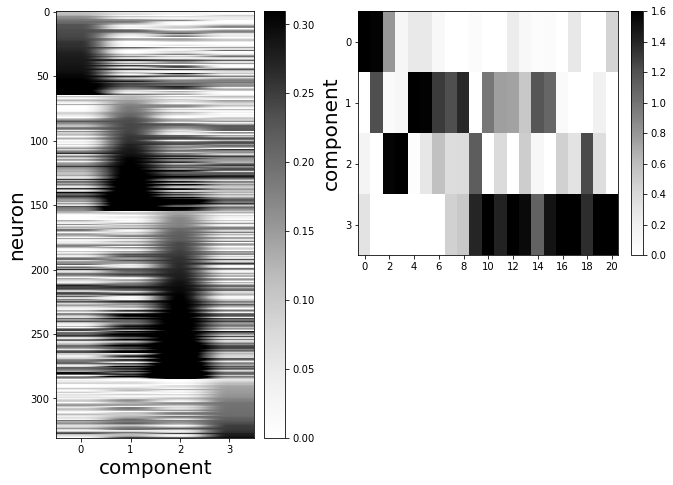

In [578]:
k='0'
nmfp.plot_wh(W_sorted_d[k],H_sorted_d[k])

In [589]:
W_df_peaks_only.loc[189]

,0,1,2,3,sum,0_normed,1_normed,2_normed,3_normed,entropy,skew,skew_0,skew_1,skew_2,skew_3
lin_binned,,,,,,,,,,,,,,,
3,0.000046,0.000000,0.000254,0.000510,0.000811,0.057284,0.000000,0.313272,0.629445,0.818807,0.521062,-0.464691,-1.014445,0.016445,3.546938
5,0.000000,0.001511,0.000000,0.003574,0.005085,0.000000,0.297139,0.000000,0.702861,0.608420,0.644487,-0.652535,0.004374,-0.652535,3.878642
8,0.019603,0.000000,0.194746,0.335725,0.550075,0.035637,0.000000,0.354036,0.610327,0.787798,0.360868,-0.633799,-1.005360,0.072452,3.010180


In [586]:
W_mean_df.loc[:,0:3].corr()

,0,1,2,3
0,1.000000,0.079909,0.059915,-0.010984
1,0.079909,1.000000,0.398388,0.420139
2,0.059915,0.398388,1.000000,0.230336
3,-0.010984,0.420139,0.230336,1.000000


In [587]:
W_mean_df = pd.DataFrame(W_sorted_d[k])
W_mean_df.index = non_na_original_ind_joint[W_inds_d[k]]

W_mean_df['factor_assignment'] = factor_assignment_d[k]
W_mean_df['name'] = cell_cols_pyr[W_mean_df.index]

f=3
W_mean_df.groupby('factor_assignment').apply(lambda x:x.sort_values(f,ascending=False)).loc[f]

,0,1,2,3,factor_assignment,name
141,0.011839,0.248169,0.207735,0.294911,3,unit_184
197,0.059937,0.120169,0.000000,0.282378,3,unit_241
228,0.090036,0.116831,0.031394,0.277922,3,unit_272
78,0.241781,0.137474,0.247509,0.277188,3,unit_121
154,0.203233,0.199212,0.064145,0.260532,3,unit_197
268,0.012155,0.000000,0.017576,0.258013,3,unit_312
71,0.077084,0.206290,0.141883,0.253714,3,unit_114
43,0.153929,0.195553,0.227198,0.251635,3,unit_85
76,0.077740,0.173932,0.105325,0.250891,3,unit_119
189,0.057204,0.097354,0.000000,0.250746,3,unit_233


In [564]:
k='0'
W_inds_d[k][factor_assignment_d[k]]

array([288, 259, 290,  92, 170, 248, 179, 136, 293, 156, 325, 126, 310,
       298, 101, 301, 143, 185, 289, 167, 129, 247, 123, 133, 253, 183,
       109, 234, 254, 205,  31, 243, 233,  30, 147, 178, 286, 199,   6,
       192,  53,  28, 221, 153, 181,  21, 246, 296, 215, 297,  36, 200,
       264, 117, 240,  44,   9,  75,  64, 213,  89, 242, 258, 175, 287,
       252, 159, 239,  77, 211, 180, 144, 174, 315, 250, 305, 306, 232,
       106,  40, 172, 222, 329, 322, 150,  38, 276, 327, 307,  61,  55,
       125, 262, 218, 196, 155, 127, 165,  51, 131, 224, 267,  37, 225,
       299,  29, 137, 161, 134, 187, 168, 309,  70, 162, 303,  95, 272,
       194,  58,  62, 284,  22, 191, 283, 130,  42,  20, 300, 112, 176,
       314,  80, 103, 108, 173, 320, 304, 302, 119, 166,  35, 241,  26,
        86,   0,  25,  14,  66, 328, 308, 157,  33,   5,  56, 135, 230,
        52, 145, 114, 209, 256, 231, 291, 245,   7, 198, 279, 124,  13,
       201, 236, 203, 295, 319,   2,  79, 182, 229,  68, 140, 31